In [93]:
import numpy as np
from scipy import optimize
from scipy import linalg
import matplotlib.pyplot as plt
import random
import cv2 as cv

In [94]:
# Import images
img1 = cv.imread('graf/img1.ppm')  
img2 = cv.imread('graf/img2.ppm')  
img3 = cv.imread('graf/img3.ppm')  
img4 = cv.imread('graf/img4.ppm')  
img5 = cv.imread('graf/img5.ppm')

In [95]:
def random_sample(data_list):
    """
    Returns a list of 3 random samples from a given list
    """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

In [96]:
def custom_sift_match(image1, image2):

    GOOD_MATCH_THRESHOLD = 0.65

    # Detect SIFT features
    sift = cv.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(image1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image2, None)

    # Match features using BFMatcher
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(descriptors_1, descriptors_2, k=2) 

    # Filter good matches using Lowe's ratio test
    good_matches = []

    for match_a, match_b in matches:
        if match_a.distance < GOOD_MATCH_THRESHOLD * match_b.distance:
            good_matches.append(match_a)

    # Extract coordinates of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, good_match in enumerate(good_matches):
        points1[i, :] = keypoints_1[good_match.queryIdx].pt
        points2[i, :] = keypoints_2[good_match.trainIdx].pt

    # Plot the matching images
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.axis('off')
    matched_image = cv.drawMatches(image1, keypoints_1, image2, keypoints_2, good_matches, image2, flags=2)
    plt.imshow(cv.cvtColor(matched_image, cv.COLOR_BGR2RGB))
    plt.show()

    result = np.concatenate((points1, points2), axis=1)

    return result


In [97]:
def custom_calculate_homography(correspondences):
    temp_list = []
    for points in correspondences:
        point1 = np.matrix([points.item(0), points.item(1), 1])  # (x1, y1)
        point2 = np.matrix([points.item(2), points.item(3), 1])  # (x2, y2)

        a2 = [0, 0, 0, -point2.item(2) * point1.item(0), -point2.item(2) * point1.item(1), -point2.item(2) * point1.item(2),
              point2.item(1) * point1.item(0), point2.item(1) * point1.item(1), point2.item(1) * point1.item(2)]
        a1 = [-point2.item(2) * point1.item(0), -point2.item(2) * point1.item(1), -point2.item(2) * point1.item(2), 0, 0, 0,
              point2.item(0) * point1.item(0), point2.item(0) * point1.item(1), point2.item(0) * point1.item(2)]
        temp_list.append(a1)
        temp_list.append(a2)

    assemble_matrix = np.matrix(temp_list)

    # Singular Value Decomposition (SVD)
    u, s, v = np.linalg.svd(assemble_matrix)

    # Reshape the smallest singular value into a 3 by 3 matrix
    homography_matrix = np.reshape(v[8], (3, 3))

    # Normalize the matrix
    homography_matrix = (1 / homography_matrix.item(8)) * homography_matrix
    
    return homography_matrix


In [98]:
def custom_loss(matched_points, homography_matrix):
    point1 = np.transpose(np.matrix([matched_points[0].item(0), matched_points[0].item(1), 1]))
    point2 = np.transpose(np.matrix([matched_points[0].item(2), matched_points[0].item(3), 1]))
    
    # Estimate the point after applying the homography
    transformed_point2 = np.dot(homography_matrix, point1)
    transformed_point2 = (1 / transformed_point2.item(2)) * transformed_point2

    # Calculate the error between the actual and estimated point
    error = point2 - transformed_point2
    
    return np.linalg.norm(error)

def RANSAC(matched_points):
    max_inliers = 0
    best_homography = None
    for _ in range(10):  # Adjust the number of iterations as needed
        random_points = random_sample(matched_points)

        # Generate the homography 
        homography = custom_calculate_homography(random_points)
        num_inliers = 0

        # Find the inliers
        for i in range(len(matched_points)):
            d = custom_loss(matched_points[i], homography)
            if d < 3:  # Adjust the threshold value as needed
                num_inliers += 1

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_homography = homography
    
    return best_homography


In [99]:
def custom_homography_reshape(homography_matrix):
    reshaped_homography = np.array(homography_matrix)
    reshaped_homography = reshaped_homography.reshape(3, 3)
    reshaped_homography = reshaped_homography / reshaped_homography[-1][-1]
    return reshaped_homography


In [100]:
def plot_warped(im1, im2, h):
    width = im1.shape[1] + im2.shape[1]
    height = im1.shape[0] + im2.shape[0]
    result = cv.warpPerspective(im1, h, (width, height))
    result[0:im2.shape[0], 0:im2.shape[1]] = im2
    fig, ax = plt.subplots(1,1,figsize= (6,6))
    ax.set_xlim(0,800)
    ax.set_ylim(645)
    ax.imshow(cv.cvtColor(result,cv.COLOR_BGR2RGB))

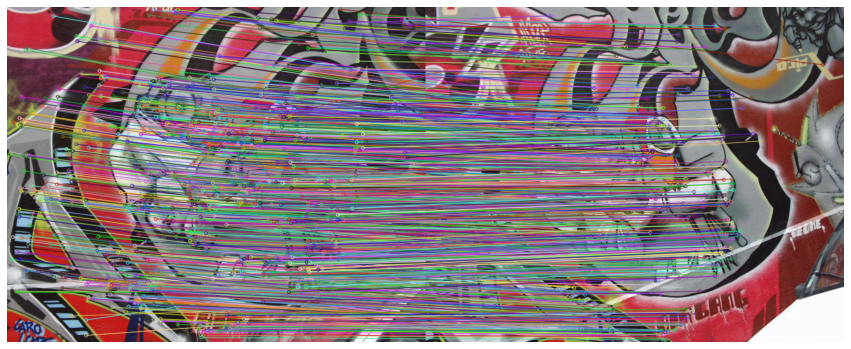

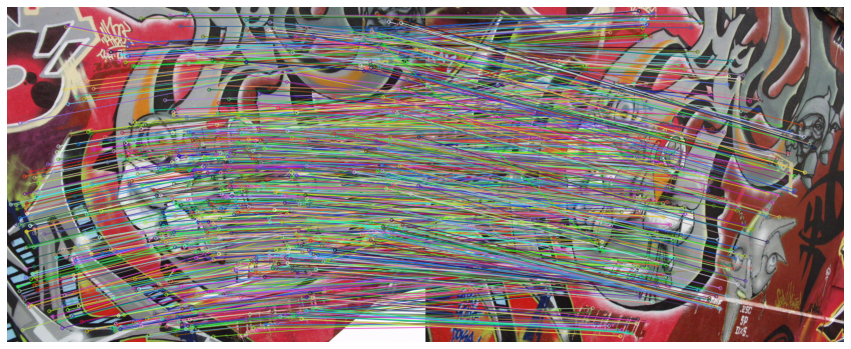

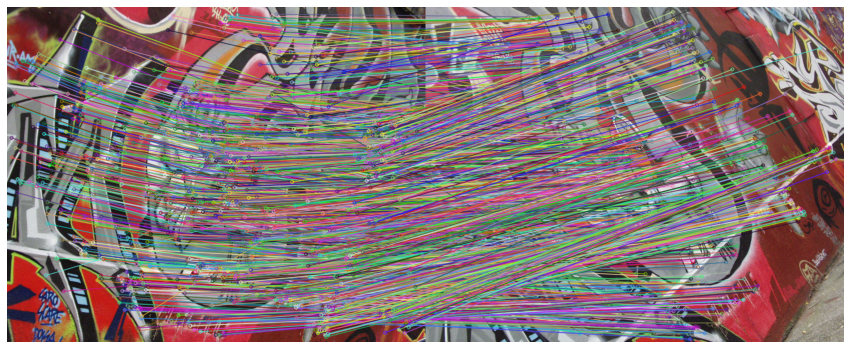

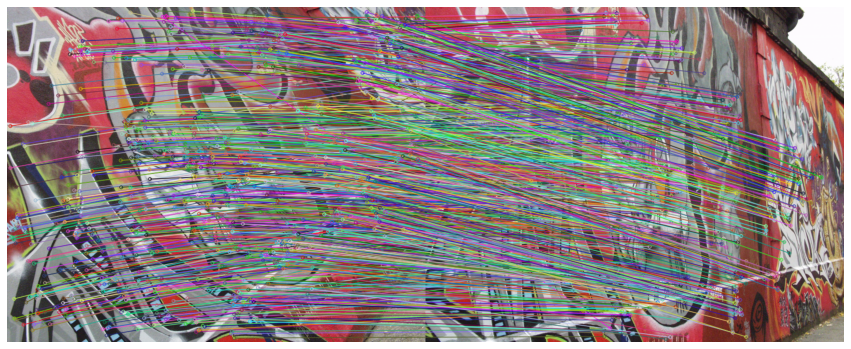

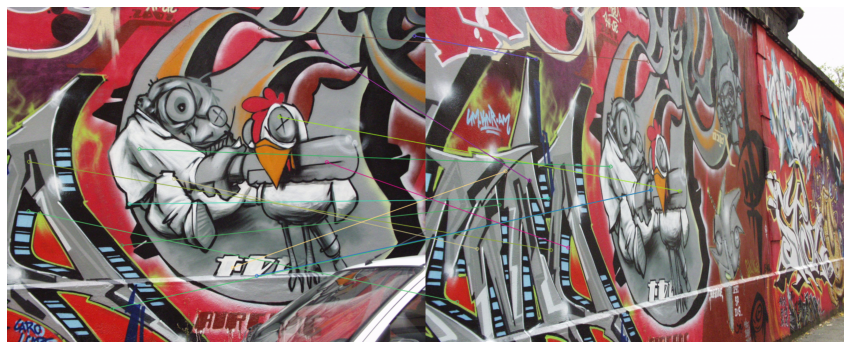

[[ 6.70443673e+00 -7.22470754e+00 -1.39447473e+00]
 [ 5.29689825e+00 -5.17070305e+00 -2.37703088e+02]
 [ 1.02250666e-02 -1.32862858e-02  1.00000000e+00]]


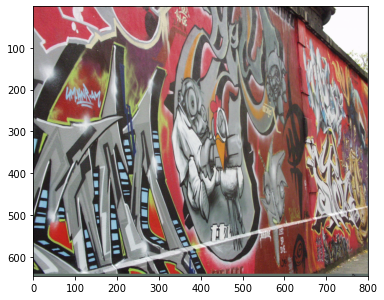

In [101]:
match1_2 = custom_sift_match(img1,img2)
match2_3 = custom_sift_match(img2,img3)
match3_4 = custom_sift_match(img3,img4)
match4_5 = custom_sift_match(img4,img5)
match1_5 = custom_sift_match(img1,img5)

# Generate Correspondence Matrices
correspondenceMatrix1_2 = np.matrix(match1_2)
correspondenceMatrix2_3 = np.matrix(match2_3)
correspondenceMatrix3_4 = np.matrix(match3_4)
correspondenceMatrix4_5 = np.matrix(match4_5)

# Run ransac algorithm
H1_2 = RANSAC(correspondenceMatrix1_2)
H2_3 = RANSAC(correspondenceMatrix2_3)
H3_4 = RANSAC(correspondenceMatrix3_4)
H4_5 = RANSAC(correspondenceMatrix4_5)

# Reshaping the homography to the matric format
H1_2 = custom_homography_reshape(H1_2)
H2_3 = custom_homography_reshape(H2_3)
H3_4 = custom_homography_reshape(H3_4)
H4_5 = custom_homography_reshape(H4_5)

H1_5 = H4_5@H3_4@H2_3@H1_2
H1_5 = custom_homography_reshape(H1_5)
print(H1_5)

plot_warped(img1,img5,H1_5)